# Classifier 연습하기

## 1 . CIFAR10을 불러오고 정규화하기

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


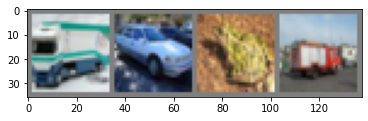

truck   car  frog truck


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


## 2 . 합성곱 신경망 정의

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3 . 손실 함수와 Optimizer 정의하기

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #learning rate

## 4 . 신경망 학습하기

In [6]:
for epoch in range(2):   # 데이터셋을 수차례 반복

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

C:\Users\Park\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 2.163
[1,  4000] loss: 1.900
[1,  6000] loss: 1.690
[1,  8000] loss: 1.608
[1, 10000] loss: 1.523
[1, 12000] loss: 1.471
[2,  2000] loss: 1.360
[2,  4000] loss: 1.337
[2,  6000] loss: 1.342
[2,  8000] loss: 1.320
[2, 10000] loss: 1.281
[2, 12000] loss: 1.265
Finished Training


## 5 . 모델 생성

In [24]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 6 . test dataset 으로 신경망 검사하기

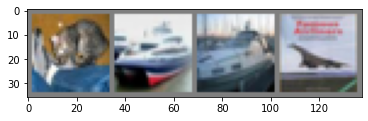

GroundTruth:    cat  ship  ship plane


In [25]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지 출력
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 7 . Training

In [26]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [27]:
outputs = net(images)

In [28]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


## 10 . Test

In [29]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [30]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않음
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모음
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 62.4 %
Accuracy for class car   is: 66.5 %
Accuracy for class bird  is: 40.8 %
Accuracy for class cat   is: 27.9 %
Accuracy for class deer  is: 54.4 %
Accuracy for class dog   is: 43.3 %
Accuracy for class frog  is: 67.2 %
Accuracy for class horse is: 60.2 %
Accuracy for class ship  is: 78.2 %
Accuracy for class truck is: 55.5 %


In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)

cpu
